#### Energy Balance Equation
$$Q_{gen} + \cancel{Q_{in}} - Q_{conv} - \cancel{W_{out}} = \frac{dU}{dt}$$

#### Busbar Specific Variables
$$(I^2 \cdot R) - (h \cdot A_s \cdot (T - T_{amb})) = m \cdot C_p \cdot \frac{dT}{dt}$$

#### Heat Generation (qgen)
$$Q_{gen} = I^2 \cdot R$$
#### Cross Sectional Area
$$A = w \cdot h_{dim}$$
#### Surface Area
$$A_s = 2 \cdot L \cdot (w + h_{dim})$$

#### Qconv (Qout)
$$Q_{conv} = h_{conv} \cdot A_s \cdot (T_{surface} - T_{ambient})$$

#### Temperature Dependance
$$R(T) = R_{ref} \cdot [1 + \alpha \cdot (T_{end} - T_{ref})]$$
#### Heat Capacity
$$Q_{stored} = m \cdot C_p \cdot \Delta T$$

#### Mass
$$m = \text{density} \times (L \cdot w \cdot h_{dim})$$


#### Heat Transfer Variables Key

| **Symbol** | **Definition**                                   | **Unit (SI)**     |
| ---------- | ------------------------------------------------ | ----------------- |
| $Q_{gen}$  | Rate of internal heat generation (Joule heating) | Watts (W)         |
| $Q_{conv}$ | Rate of heat loss via convection                 | Watts (W)         |
| $I$        | Electrical current flowing through the busbar    | Amperes (A)       |
| $R$        | Electrical resistance (temp-dependent)           | Ohms ($\Omega$)   |
| $R_{ref}$  | Resistance at the reference temperature          | Ohms ($\Omega$)   |
| $\rho$     | Electrical resistivity of the material           | $\Omega \cdot m$  |
| $L$        | Length of the busbar                             | Meters (m)        |
| $w$        | Width of the busbar                              | Meters (m)        |
| $h_{dim}$  | Height of the busbar                             | Meters (m)        |
| $A$        | Cross-sectional area                             | $m^2$             |
| $A_s$      | Surface area for cooling                         | $m^2$             |
| $h$        | Convective heat transfer coefficient             | $W/(m^2 \cdot K)$ |
| $T$        | Instantaneous temperature of the busbar          | $^\circ C$ or $K$ |
| $T_{amb}$  | Ambient temperature of the surrounding air       | $^\circ C$ or $K$ |
| $T_{ref}$  | Reference temperature (usually $20^\circ C$)     | $^\circ C$ or $K$ |
| $\alpha$   | Temperature coefficient of resistance            | $1/^\circ C$      |
| $m$        | Mass of the busbar                               | Kilograms (kg)    |
| $C_p$      | Specific heat capacity of the material           | $J/(kg \cdot K)$  |
| $t$        | Time                                             | Seconds (s)       |


In [11]:
%pip install numpy matplotlib pandas ipywidgets

Note: you may need to restart the kernel to use updated packages.


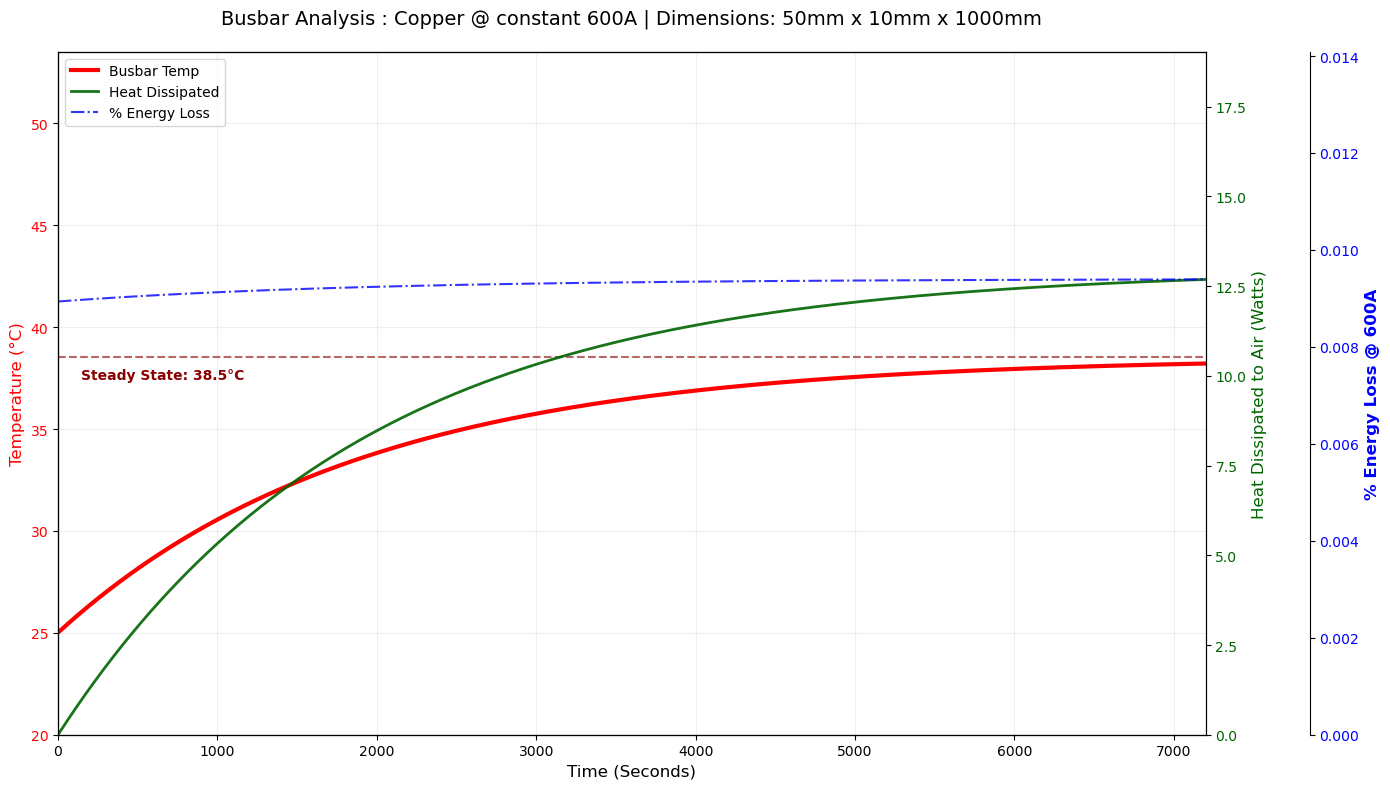

,Parameter,Value
0,Material,Copper
1,Dimensions (W x H x L),50mm x 10mm x 1000mm
2,Mass,4.480 kg
3,Current,600 A
4,Steady State Temp,38.52 °C
5,Final Energy Loss,0.0094 %


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. MATERIAL DATABASE
materials = {
    'Copper': {'density': 8960, 'Cp': 385, 'alpha': 0.00393, 'rho_ref': 1.68e-8},
    'Aluminum': {'density': 2700, 'Cp': 897, 'alpha': 0.0039, 'rho_ref': 2.82e-8},
    'Brass': {'density': 8500, 'Cp': 377, 'alpha': 0.0020, 'rho_ref': 7.0e-8}
}

# 2. INPUTS
CHOSEN_MATERIAL = 'Copper'
I = 600                     # Current (A)
total_time = 7200           # 2 hours
V_load = 600                # System Voltage

# Realistic Dimensions (in meters)
L, w, h_dim = 1.0, 0.050, 0.010  
h_conv = 8       
T_amb, T_ref = 25, 20                     

# 3. SETUP & STEADY STATE
mat = materials[CHOSEN_MATERIAL]
A = w * h_dim
As = 2 * L * (w + h_dim)
mass = mat['density'] * (L * w * h_dim)
R_ref = mat['rho_ref'] * (L / A)

# Analytical Steady State
num = (I**2 * R_ref * (1 - mat['alpha'] * T_ref)) + (h_conv * As * T_amb)
den = (h_conv * As) - (I**2 * R_ref * mat['alpha'])
T_steady = num / den

# 4. SIMULATION ENGINE
dt = total_time / 5000
steps = int(total_time / dt)
time_axis = np.linspace(0, total_time, steps)

temp_history, q_conv_history, loss_history = np.zeros(steps), np.zeros(steps), np.zeros(steps)
T_current = T_amb 

for i in range(steps):
    R_t = R_ref * (1 + mat['alpha'] * (T_current - T_ref))
    Q_gen = (I**2) * R_t
    Q_conv = h_conv * As * (T_current - T_amb)
    
    P_total = (I * V_load) + Q_gen
    energy_loss_pct = (Q_gen / P_total) * 100
    
    dT_dt = (Q_gen - Q_conv) / (mass * mat['Cp'])
    T_current += dT_dt * dt
    
    temp_history[i], q_conv_history[i], loss_history[i] = T_current, Q_conv, energy_loss_pct

# 5. VISUALIZATION
fig, ax1 = plt.subplots(figsize=(14, 8))

# Temp Axis (Left)
ax1.plot(time_axis, temp_history, color='red', linewidth=3, label='Busbar Temp', zorder=5)
ax1.axhline(y=T_steady, color='darkred', linestyle='--', alpha=0.6, zorder=4)
ax1.text(total_time*0.02, T_steady - 0.5, f'Steady State: {T_steady:.1f}°C', 
         color='darkred', fontweight='bold', va='top')

ax1.set_xlabel('Time (Seconds)', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xlim(0, total_time)
ax1.set_ylim(T_amb - 5, T_steady + 15) 

# Heat Dissipation Axis (Right 1)
ax2 = ax1.twinx()
ax2.plot(time_axis, q_conv_history, color='darkgreen', linewidth=2, alpha=0.9, label='Heat Dissipated')
ax2.set_ylabel('Heat Dissipated to Air (Watts)', color='darkgreen', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkgreen')
ax2.set_ylim(0, max(q_conv_history) * 1.5) 

# Energy Loss Axis (Right 2)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 75))
ax3.plot(time_axis, loss_history, color='blue', linestyle='-.', alpha=0.8, label='% Energy Loss')
ax3.set_ylabel(f'% Energy Loss @ {I}A', color='blue', fontsize=12, fontweight='bold')
ax3.tick_params(axis='y', labelcolor='blue')
ax3.set_ylim(0, max(loss_history) * 1.5) 

# Updated Title Format
l_str, w_str, h_str = f"{L*1000:g}mm", f"{w*1000:g}mm", f"{h_dim*1000:g}mm"
plt.title(f'Busbar Analysis : {CHOSEN_MATERIAL} @ constant {I}A | Dimensions: {w_str} x {h_str} x {l_str}', 
          fontsize=14, pad=20)

ax1.grid(True, alpha=0.2)

# Legend (Top Left)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')

fig.tight_layout()
plt.show()

# 6. SUMMARY TABLE
summary_df = pd.DataFrame({
    "Parameter": ["Material", "Dimensions (W x H x L)", "Mass", "Current", "Steady State Temp", "Final Energy Loss"],
    "Value": [CHOSEN_MATERIAL, f"{w_str} x {h_str} x {l_str}", f"{mass:.3f} kg", f"{I} A", f"{T_steady:.2f} °C", f"{loss_history[-1]:.4f} %"]
})
display(summary_df)